<table>
<tr>
    <td><img src="img/gibbon_993.png"/></td>
    </tr>
</table>
<h1 align=center>Ceci n'est pas un panda</h1>

<table>
<tr>
    <td><img src="img/panda_577.png"/></td>
    <td><img src="img/nematode_082.png"/></td>
    <td><img src="img/gibbon_993.png"/></td>
    </tr>
</table>

> "Explaining and Harnessing Adversarial Examples", Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy [arXiv:1412.6572](https://arxiv.org/abs/1412.6572)

# Adversarial Examples

In [1]:
import os
from IPython.display import clear_output, display

import numpy as np


import matplotlib.pyplot as plt

import torch as t
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, BatchNorm1d
import torchvision

import utils as u


In [2]:
%matplotlib inline

In [3]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [4]:
#device=t.device('cpu')

## MNIST 

In [5]:
from keras.datasets import mnist

Using TensorFlow backend.


In [6]:
(x_train,y_train), (x_test, y_test) = mnist.load_data()

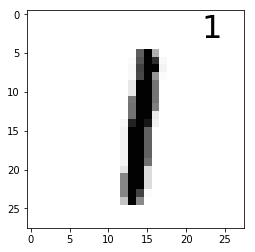

In [7]:
index=40
plt.imshow(x_train[index], cmap='Greys')
plt.text(22,3,'%d' % (y_train[index],), fontsize=32);

In [8]:
train_dataset = u.make_dataset(x_train, y_train, device)
test_dataset  = u.make_dataset(x_test, y_test, device) 

In [9]:
train_loader = t.utils.data.DataLoader(train_dataset, batch_size=128)

In [10]:
if os.path.isfile('mnist_home_model.pt'):
    model = t.load('mnist_home_model.pt')
    pretrained = True
else:        
    model = u.make_model(32, drop=0.0)
    model.apply(u.init_layer)
    pretrained = False

```python 
def make_model(width, drop):
    return t.nn.Sequential(t.nn.Linear(28*28, 2*width), 
                           t.nn.Dropout(drop), t.nn.ReLU(),
                           t.nn.Linear(2*width, width), 
                           t.nn.Dropout(drop),  t.nn.ReLU(),
                           t.nn.Linear(width, width),
                           t.nn.Dropout(drop),  t.nn.ReLU(),
                           t.nn.Linear(width, 10)
                   )
```

In [11]:
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): Dropout(p=0.0)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Dropout(p=0.0)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Dropout(p=0.0)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
u.accuracy(model, test_dataset[:][0], test_dataset[:][1])

0.0899

In [13]:
ce = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.0002)

epoch 19 0.050522 0.093850 0.969900
CPU times: user 2min 39s, sys: 1.28 s, total: 2min 40s
Wall time: 21.6 s


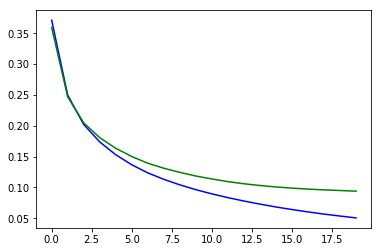

In [14]:
%%time
if not pretrained:
    err_train=[]
    err_valid=[]
    for epoch in range(20):    
        for datum in train_loader:
            optimizer.zero_grad()
            (features,target) = datum
            pred = model(features)
            loss = ce(pred, target)
            loss.backward()
            optimizer.step()

        with t.no_grad():
            vpred  = model(test_dataset[:][0])
            vloss  = ce(vpred,test_dataset[:][1])
            err_valid.append(vloss)
            pred  = model(train_dataset[:][0])
            loss  = ce(pred,train_dataset[:][1])
            err_train.append(loss)
        clear_output()
        print("epoch %d %f %f %f" % (epoch, loss, vloss,u.accuracy(model, 
                                                                   test_dataset[:][0],  test_dataset[:][1])))   

    plt.plot(err_train,c='b')
    plt.plot(err_valid,c='g')

In [15]:
print(u.accuracy(model, test_dataset[:][0],  test_dataset[:][1]) )
print(u.accuracy(model, train_dataset[:][0], train_dataset[:][1]) )

0.9699
0.9862


In [16]:
if not os.path.isfile('mnist_home_model.pt'):
    t.save(model,"mnist_home_model.pt")

In [17]:
example = t.load('real_5.pt').to(device)
fake    = t.load('fake_4.pt').to(device)

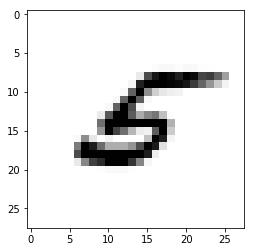

In [18]:
u.display(example.cpu())

In [19]:
u.prediction(model,example)

(5, 0.9969627261161804)

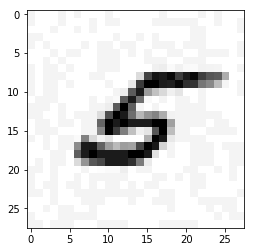

In [20]:
u.display(fake.cpu())

In [21]:
u.prediction(model,fake)

(4, 0.6050131916999817)

## Rubish class

In [22]:
A = t.empty(1,28*28,device=device).uniform_(0,1)
A.requires_grad_(True);

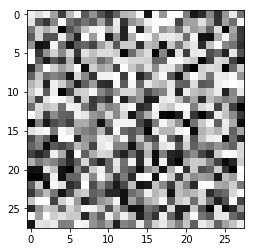

In [23]:
plt.imshow(A.data.cpu().numpy().reshape(28,28), cmap='Greys')

In [24]:
u.prediction(model, A)

(3, 0.8644260168075562)

$$\newcommand{\argmin}{\operatorname{argmin}}$$
$$\argmin_A J(A, target)$$

In [25]:
target = t.LongTensor([4]).to(device)

In [26]:
pred = model(A)
ce(pred,target)

tensor(46.5689, grad_fn=<NllLossBackward>)

In [27]:
u.model_detach(model)

In [28]:
adv_optimizer = t.optim.SGD([A],lr=0.002)

In [29]:
%%time
for i in range(5000):
    adv_optimizer.zero_grad()
    pred = model(A)
    loss =ce(pred,target)
    loss.backward()
    adv_optimizer.step()
    #clear_output()
print(loss.item())

0.0025358200073242188
CPU times: user 15.9 s, sys: 67.6 ms, total: 16 s
Wall time: 1.46 s


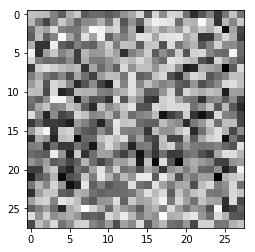

In [30]:
plt.imshow(A.data.cpu().numpy().reshape(28,28), cmap='Greys')

In [31]:
pred = model(A)
ce(pred,target)

tensor(0.0025, grad_fn=<NllLossBackward>)

In [32]:
u.prediction(model, A)

(4, 0.9974683523178101)

## Source/Target  attack

In [33]:
idx = 490
X = train_dataset[idx:idx+1][0].clone()
L = train_dataset[idx:idx+1][1]
print(L.item())

3


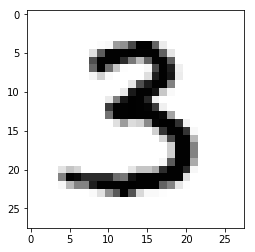

In [34]:
plt.imshow(X.data.cpu().numpy().reshape(28,28), cmap='Greys')

In [35]:
A = t.empty(1,28*28,device=device).uniform_(0,1)
A.requires_grad_(True);

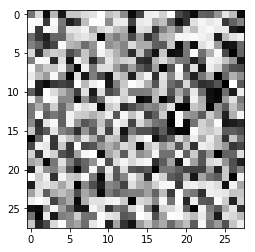

In [36]:
plt.imshow(A.data.cpu().numpy().reshape(28,28), cmap='Greys')

In [37]:
u.prediction(model, A)

(3, 0.9499902725219727)

In [38]:
target = t.LongTensor([4]).to(device)

In [39]:
pred = model(A)
ce(pred,target)

tensor(44.4248, grad_fn=<NllLossBackward>)

In [40]:
adv_optimizer = t.optim.Adam([A],lr=0.0001, betas=(0.5, 0.999))

In [41]:
%%time
for i in range(20000):
    adv_optimizer.zero_grad()
    pred = model(A)
    loss =ce(pred,target)+1.4*t.norm(A-X)
    loss.backward()
    adv_optimizer.step()
    #clear_output()
print(loss.item())

2.2743234634399414
CPU times: user 1min 28s, sys: 363 ms, total: 1min 29s
Wall time: 8.22 s


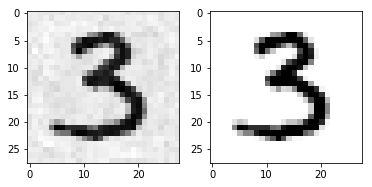

In [42]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(A.data.cpu().numpy().reshape(28,28), cmap='Greys')
ax[1].imshow(X.data.cpu().numpy().reshape(28,28), cmap='Greys')

In [43]:
pred = model(A)
ce(pred,target)

tensor(0.1459, grad_fn=<NllLossBackward>)

In [44]:
u.prediction(model, A)

(4, 0.8642539381980896)

In [45]:
noise = A-X

In [46]:
t.max(noise.abs() )

tensor(0.2111, grad_fn=<MaxBackward1>)

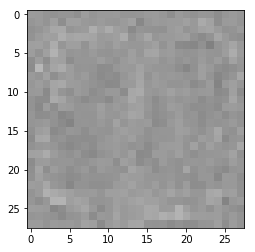

In [47]:
plt.imshow(noise.data.cpu().numpy().reshape(28,28), cmap='Greys', vmin=-1, vmax = 1 )

In [48]:
u.prediction(model, X+noise)

(4, 0.8642539381980896)

## Taxonomy 

<img src="img/taxonomy-lattice.png" width="600"/>

> "The Limitations of Deep Learning in Adversarial Settings", Nicolas Papernot, Patrick McDaniel, Somesh Jha, Matt Fredrikson, Z. Berkay Celik, Ananthram Swami [arXiv:1511.07528](https://arxiv.org/abs/1511.07528)


## Real World Examples 

> "Adversarial examples in the physical world", Alexey Kurakin, Ian Goodfellow, Samy Bengio [arXiv:1607.02533](https://arxiv.org/abs/1607.02533)

<table>
    <tr>
        <td><img src="img/img0413.png"/></td>
        <td><img src="img/DemoWasher_Clean.jpg"/></td>
    </tr>
</table>    

<table>
    <tr>
        <td><img src="img/DemoWasher_Eps4.jpg"/></td>
        <td><img src="img/images/DemoWasher_Eps8.jpg"/></td>
    </tr>
</table>    

> "Robust Physical-World Attacks on Deep Learning Models", Kevin Eykholt, Ivan Evtimov, Earlence Fernandes, Bo Li, Amir Rahmati, Chaowei Xiao, Atul Prakash, Tadayoshi Kohno, Dawn Song [arXiv:1707.08945](https://arxiv.org/abs/1707.08945).

<table>
    <tr>
        <td><img src="img/invisible-poster-05ft-0deg.jpg"/></td>
        <td><img src="img/invisible-poster-05ft-15deg.jpg"/></td>
    </tr>
</table>

<table>
    <tr>
        <td><img src="img/rightturn-poster-05ft-0deg.jpg"/></td>
        <td><img src="img/rightturn-poster-05ft-15deg.jpg"/></td>
    </tr>
</table>

<table>
    <tr>
        <td><img src="img/subliminal-graffiti-sticker-05ft-0deg.jpg"/></td>
        <td><img src="img/subliminal-graffiti-sticker-05ft-15deg.jpg"/></td>
    </tr>
</table>

<table>
    <tr>
        <td><img src="img/subliminal-art-sticker-05ft-0deg.jpg"/></td>
        <td><img src="img/subliminal-art-sticker-05ft-15deg.jpg"/></td>
    </tr>
</table>